### 관련 라이브러리 로드

In [ ]:
# 한국어 폰트를 설치합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import pandas as pd
import numpy as np
import copy
import random

import matplotlib.pyplot as plt
import seaborn as sns
# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
sns.set_style('whitegrid')
plt.rc('font', family='NanumBarunGothic')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## 1. Confusion Matrix 소개
Confusion Matrix는 실제 값과 예측 값을 바탕으로 정사각행렬을 구성하여 다양한 분류 모형 평가 지표 계산을 용이하도록 합니다. \
Confusion Matrix를 이용하여 계산할 수 있는 지표 4가지와 공식은 아래와 같습니다.
1. **정확도 (Accuracy):**

   $\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$

2. **정밀도 (Precision):**

   $\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$

3. **재현율 (Recall):**

   $\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$

4. **F1 점수 (F1 Score):**

   $\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$
​


![](https://miro.medium.com/v2/resize:fit:1218/1*jMs1RmSwnYgR9CsBw-z1dw.png)

Confusion Matrix를 이용하여 accuracy, recall, precision, f1 score 계산이 간단히 이루어지기 때문에, 아래와 같이 하나의 함수를 통해 구현이 가능합니다. \
AUROC의 경우 향후 실습을 통해서 직접 구현 방식을 확인해보도록 하겠습니다.

In [ ]:
def get_metric(prediction, prob, actual) :
    # prediction : 예측값
    # actual : 실제값
    # confusion_matrix : 정오행렬
    # TP : True Positive
    # TN : True Negative
    # FP : False Positive
    # FN : False Negative
    # accuracy : 정확도
    # precision : 정밀도
    # recall : 재현율
    # f1-score : F1 점수
    # support : 데이터 건수
    confusion_matrix = pd.crosstab(prediction, actual, rownames=['Predicted'], colnames=['Actual'], margins=True)
    accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / (confusion_matrix[0][0] + confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1])
    precision = confusion_matrix[1][1] / (confusion_matrix[0][1] + confusion_matrix[1][1])
    recall = confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])
    f1_score = 2 * precision * recall / (precision + recall)
    auroc = metrics.roc_auc_score(actual, prob[:,0])
    return confusion_matrix, accuracy, precision, recall, f1_score, auroc

다만, 각 요소의 구동 방식을 이해하기 위해 하나씩 진행해보도록 하겠습니다.

#### 1-0. 예시 데이터
다음과 같은 모델의 예측값과 실제 값이 있다고 하겠습니다.  
이때, 저희가 집중적으로 관찰하고 싶은 예측 범주(공정 상 불량 제품 여부)를 1로 설정하고, 이외 범주(정상 제품)을 0으로 설정하겠습니다.

In [ ]:
prediction          = [1, 1, 1, 1, 1, 0, 0, 0, 0, 1]
actual              = [1, 0, 1, 1, 1, 0, 1, 0, 0, 0]

confusion_matrix = pd.crosstab(prediction, actual, rownames=['Predicted'], colnames=['Actual'])
confusion_matrix

Actual,0,1
Predicted,,
0,3,1
1,2,4


#### 1-1. Accuracy 계산

정확도는 아래와 같이 구성되므로 실제 Confusion Matrix의 해당 성분을 이용하여 계산할 수 있습니다.  
$$ accuracy = {(n_{11} + n_{00}) \over (n_{11} + n_{10} + n_{01} + n_{00})} $$

In [ ]:
accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / (confusion_matrix[0][0] + confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1])
accuracy

0.7

#### 1-2. Recall 계산

재현율은 아래와 같이 구성되므로 실제 Confusion Matrix의 해당 성분을 이용하여 계산할 수 있습니다.  
$$ recall = {n_{11} \over (n_{11} + n_{10})} $$

In [ ]:
recall = confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])
recall

0.8

#### 1-3. Precision 계산
정밀도는 아래와 같이 구성되므로 실제 Confustion Matrix의 해당 성분을 이용하여 계산할 수 있습니다.
$$ precision = {n_{11} \over (n_{11} + n_{01})} $$

In [ ]:
precision = confusion_matrix[1][1] / (confusion_matrix[0][1] + confusion_matrix[1][1])
precision

0.6666666666666666

#### 1-4. F1 Score 계산
F1 Score는 아래와 같이 구성되므로 실제 Confusion Matrix에서 계산된 recall과 precision을 이용하여 계산할 수 있습니다.  
$$ F1 Score = {2 \times recall \times precision \over recall + precision} $$

In [ ]:
f1_score = 2 * precision * recall / (precision + recall)
f1_score

0.7272727272727272

#### 1-5. AUROC 계산
AUROC는 모델의 예측 확률을 기반으로 계산됩니다. \
그러므로 이전까지의 계산과 다르게 모델이 각 데이터에 대해 1일 확률을 예측한 값을 기반으로 아래와 같이 계산될 수 있습니다. \
실제 계산 시에는 sklearn 패키지 내의 함수를 이용합니다. 하지만 동작 원리를 파악하기 위해서 아래 순으로 확인해봅시다.
1) fpr, tpr 계산 공식
2) 사다리꼴 넓이 계산 공식
3) AUROC 계산 함수

### 1-5-1. FPR, TPR 계산 함수

FPR은 False Positive Rate으로서 실제로 Negative(1)인 객체들에 대해 모델이 Positive(0)로 예측한 비율을 의미합니다. 공식으로 표현하면 아래와 같습니다.

$$ FPR = {n_{01} \over (n_{01} + n_{00})} $$

TPR은 True Positive Rate으로서 실제로 Positive인 객체들에 대해 모델이 Positive로 옳바르게 예측한 비율을 의미합니다. 공식으로 표현하면 아래와 같습니다.

$$ TPR = {n_{11} \over (n_{11} + n_{10})} $$




In [ ]:
## 위 두 공식을 함수로 구현하면 아래와 같습니다.
def get_TPR(confusion_matrix) :
    # TPR : True Positive Rate
    # TPR : True Positive / (True Positive + False Negative)
    return confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])

def get_FPR(confusion_matrix) :
    # FPR : False Positive Rate
    # FPR : False Positive / (False Positive + True Negative)
    return confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])


### 1-5-2. Threshold 별 TPR, FPR 계산

ROC는 모델이 예측한 확률에 대해 Threhold를 변경하며, 실제 예측값을 결정하면서 TPR과 FPR의 비율 변화를 모두 기록한 것입니다. 이는 1) Threshold를 변경하며 TPR과 FPR 계산 2) TPR과 FPR을 이용하여 Curve의 아래 넓이 계산 두 함수로 구현될 수 있습니다.

In [ ]:
def get_confusion_matrix(prediction, actual) :
    return pd.crosstab(prediction, actual, rownames=['Predicted'], colnames=['Actual'])

In [ ]:
def get_sadari(x_start, x_end, y_small, y_large) :
    """
    AUROC는 사다리꼴 너비의 합으로 계산됩니다.
    사다리꼴 너비를 구하는 함수입니다.
    """
    return (y_small + y_large) * (x_end - x_start) / 2

def get_AUROC(prediction, actual) :
    """
    AUROC : Area Under the Receiver Operating Characteristic Curve
    ROC 곡선의 아래 면적을 구하는 함수입니다.
    """
    # 1. prediction은 확률이므로, prediction을 기준으로 정렬합니다.

    prediction_sorted, actual_sorted = zip(*sorted(zip(prediction, actual), reverse=True))

    # 2. prediction을 기준으로 정렬된 actual을 기준으로 TPR, FPR을 구합니다.
    TPR_list = []
    FPR_list = []
    for i in range(len(prediction_sorted)) :
        if i != len(prediction_sorted) - 1 :
            if prediction_sorted[i] == prediction_sorted[i+1] :
                continue
        prediction_ = [0]*len(prediction_sorted)
        prediction_[:i+1] = [1]*(i+1)
        confusion_matrix = get_confusion_matrix(prediction_, actual_sorted)
        if confusion_matrix.shape != (2,2) :
            confusion_matrix = pd.DataFrame([[0,0],[0,0]])
        TPR = get_TPR(confusion_matrix)
        FPR = get_FPR(confusion_matrix)
        TPR_list.append(TPR)
        FPR_list.append(FPR)

    # 3. TPR, FPR을 기준으로 사다리꼴의 너비를 구합니다.
    AUROC = 0
    for i in range(len(TPR_list) - 2) :
        print(get_sadari(FPR_list[i], FPR_list[i+1], TPR_list[i], TPR_list[i+1]))
        AUROC += get_sadari(FPR_list[i], FPR_list[i+1], TPR_list[i], TPR_list[i+1])
    return AUROC, TPR_list, FPR_list

<ipython-input-32-678b82025585>:5: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])
<ipython-input-32-678b82025585>:10: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])


0.0
0.0
0.13999999999999999
0.16000000000000003
0.32000000000000006


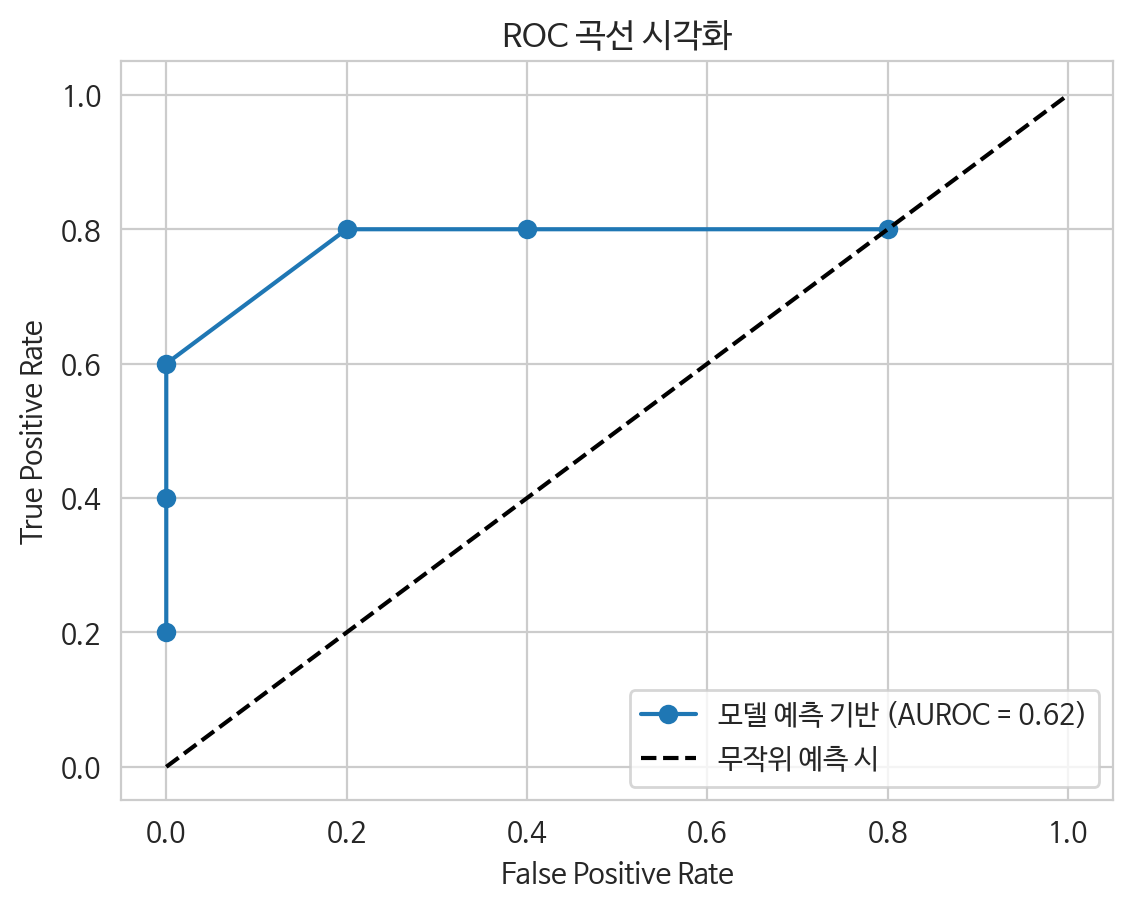

In [ ]:
actual     = [1, 0, 1, 1, 1, 0, 1, 0, 0, 0]
prediction = [0.9, 0.6, 0.6, 0.8, 0.7, 0.2, 0.1, 0.3, 0.2, 0.1]
auroc, tpr, fpr = get_AUROC(prediction, actual)
plt.plot(fpr, tpr, 'o-', label="모델 예측 기반 (AUROC = %0.2f)" % auroc)
plt.plot([0, 1], [0, 1], 'k--', label="무작위 예측 시")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 곡선 시각화')
plt.legend(loc="lower right")
plt.show()

실제로 아래 웹사이트를 통해 AUROC 커브가 생성되는 과정을 자세히 살펴볼 수 있습니다.  
https://arogozhnikov.github.io/2015/10/05/roc-curve.html  
모델이 잘못 예측한 값이 적을수록, TPR과 FPR이 겹치는 영역이 줄어들게 되고, threshold 변화에 따라 trade-off 관계가 적어지게 됩니다.  
결과적으로 이를 통해 아래 그림처럼 ROC 커브 아래의 크기가 커지고, AUROC(Area Under ROC) 값이 커지는 효과를 얻을 수 있습니다.

![AUROC.git](https://arogozhnikov.github.io/images/roc_curve.gif)

#### 1-6. BCR 계산
BCR은 실제 각 클래스별 데이터 중 예측에 성공한 데이터 비율의 곱으로 계산됩니다.
BCR은 위에서 준비된 정오 행렬에서 간단하게 산출할 수 있습니다.

In [ ]:
def get_BCR(confusion_matrix) :
    num_of_class_0 = np.sum(confusion_matrix[0])
    num_of_class_1 = np.sum(confusion_matrix[1])

    BCR = ((confusion_matrix[0][0] / num_of_class_0) * (confusion_matrix[1][1] / num_of_class_1))**0.5
    return BCR

print(get_BCR(confusion_matrix))

0.6928203230275509


### 1-7. 최종 지표 계산 함수
최종적으로 저희가 살펴볼 모든 지표들을 반환해주는 함수를 아래와 같이 작성해줍니다.

In [ ]:
def get_metric(prediction, pred_proba, actual) :
    # prediction : 예측값
    # actual : 실제값
    # pred_proba : 예측 확률
    # confusion_matrix : 정오행렬
    # TP : True Positive
    # TN : True Negative
    # FP : False Positive
    # FN : False Negative
    # accuracy : 정확도
    # precision : 정밀도
    # recall : 재현율
    # f1-score : F1 점수
    # support : 데이터 건수
    confusion_matrix = pd.crosstab(prediction, actual, rownames=['Predicted'], colnames=['Actual'], margins=True)
    accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1]) / (confusion_matrix[0][0] + confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1])
    precision = confusion_matrix[1][1] / (confusion_matrix[0][1] + confusion_matrix[1][1])
    recall = confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])
    f1_score = 2 * precision * recall / (precision + recall)
    auroc = metrics.roc_auc_score(actual, pred_proba[:, 1])
    bcr = get_BCR(confusion_matrix)
    return confusion_matrix, accuracy, precision, recall, f1_score, auroc, bcr

## 2. 데이터 소개

실습 데이터셋은 sklearn의 make_classification 함수를 통해 임의로 생성해보도록 하겠습니다.

sklearn은 데이터 분석 및 모델 구축을 위한 라이브러리로 머신러닝 분야에서 표준적으로 사용되는 라이브러리입니다.
해당 라이브러리는 모델 학습/테스트/평가지표/시각화 등 다양한 기능을 제공하고 있습니다.

make_classification 함수는 그 중에서도 분류 문제에 적합한 데이터를 임의로 만들어 테스트할 수 있도록 도와주는 함수입니다.

자세한 내용은 아래 사이트를 통해 확인해보실 수 있습니다.
- make_classification 함수 내 파라미터 설명 : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

실습에서 사용될 데이터는 아래와 같은 조건을 가지고 있게 됩니다.
- 데이터 수 : 1,000건
- 변수 수 : 20건
- 클래스 수 : 2개
- 클래스 비율 : 1 대 9

생성된 데이터의 클래스 비율은 의도적으로 1대 9로 설정해보겠습니다. \
실제 수집되는 데이터의 비율은 1대1인 경우가 가장 이상적이지만, 현실 상황에서 수집되는 다양한 데이터는 특정 클래스가 매우 많거나 적은 상황이 자주 발생합니다. \
금일 실습에서는 이러한 데이터 불균형 상황에서 모델의 능력을 평가하는 방법론을 다뤄보도록 하겠습니다.

In [ ]:
from sklearn.datasets import make_classification

In [ ]:
dataset = make_classification(
    n_samples=5000,
    n_features=50,
    n_informative=40,
    n_redundant=3,
    n_repeated=0,
    n_classes=2,
    random_state=42,
    class_sep=0.1,
    weights=[0.05, 0.95]
    )

In [ ]:
# X : 독립변수, y : 종속변수
# X를 입력으로 하여 y를 예측하는 문제입니다.
X, y = dataset

In [ ]:
print(X[:2])

[[-6.61530467e+00  1.75291028e+00  2.11218810e+01 -6.84159642e+00
   5.09155750e+00  3.38078434e-03  4.77380292e-01  3.17119653e+00
  -3.28766948e+00 -3.26343449e+00 -5.33339968e+00 -3.52140449e-01
   1.13171350e+00  3.23220322e-01  1.29366237e+01  1.94521661e+00
  -4.50120339e+00 -3.66373175e-01  3.53133969e+00  2.01681245e-01
  -3.07213416e+00  2.22943262e+00  6.43038763e-01 -1.47372124e+00
  -8.79577730e-01 -9.07351970e+00  2.51379466e+00  2.62141245e-01
  -5.75967413e+00  9.25355768e-01  3.99281858e+00  3.20018980e+00
   2.44870298e-01 -4.36808115e-01 -3.99455077e+00  5.65008286e+00
   2.84575636e-01  4.46078257e-01  1.68734290e-01  2.50649917e-01
   1.08772855e+00 -5.18420231e-01 -3.05302119e-01  1.29511131e+00
   3.37956906e-01  8.57358366e+00  1.34786177e+00 -1.66362640e+00
  -9.55881687e-01 -8.09935678e+00]
 [-3.91447003e+00  5.34778423e+00 -2.80746467e+00 -1.65608289e+00
  -4.59608434e+00 -5.11917295e-01 -6.58835690e-01  7.16509443e-01
  -1.20815069e+00  8.87981300e-02 -3.0066

In [ ]:
print(y[:2])

[1 1]


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


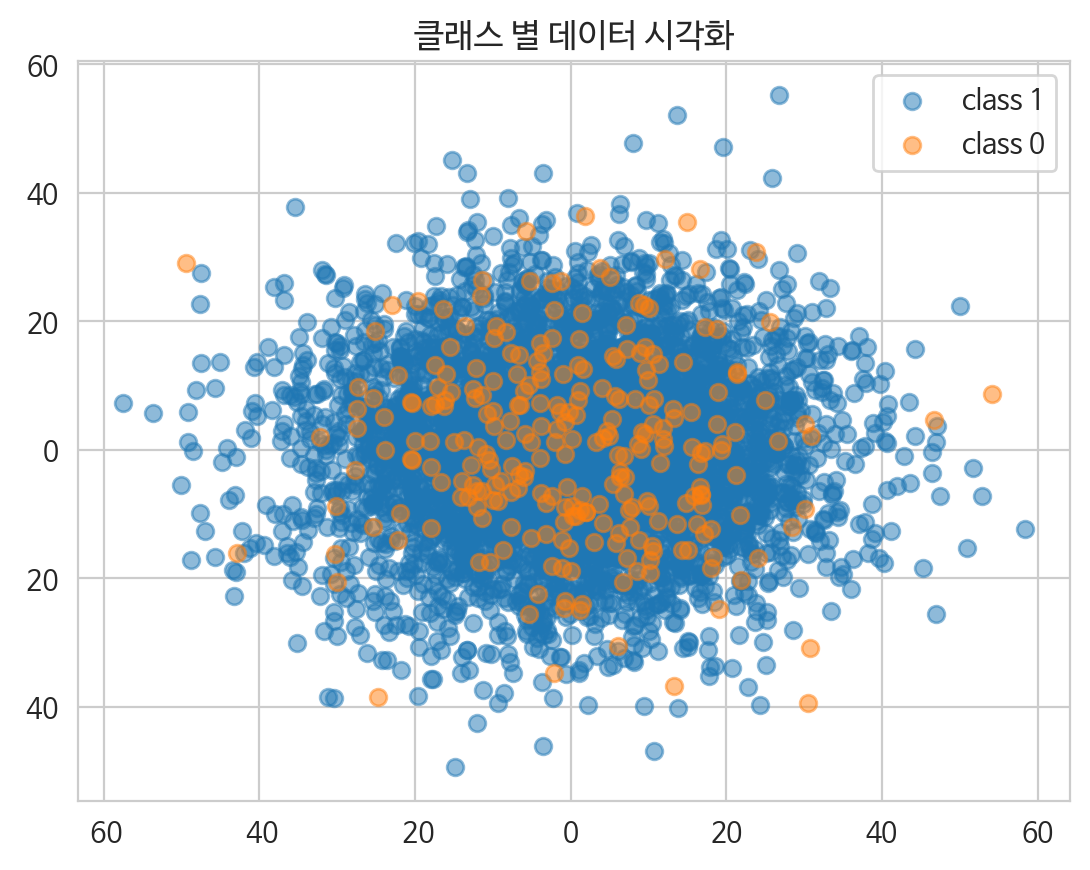

In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
X_for_pca = X
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_for_pca)

# scatter plot을 그립니다.
# c : 색상, s : 크기
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label="class 1", alpha=0.5)
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label="class 0", alpha=0.5)
plt.title('클래스 별 데이터 시각화')
plt.legend()
plt.show()

### 3. 데이터 분할
주어진 데이터를 분할하여 학습/평가/테스트 용 데이터를 생성하도록 하겠습니다. \
이때 테스트용 데이터는 실제 서비스 및 공정 적용 상황이라 가정하고, 모델 평가 과정에 반영되지 않습니다. \
모델 개발 시에는 기존에 확보된 데이터를 이용하여 최적의 모델을 학습/선정해야 하기 때문에, 학습 및 평가 데이터를 이용하게 됩니다.

분류 문제에서 데이터 분할 시 고려해야 하는 점은 데이터 내 실제 label의 분포입니다. 즉, 학습/평가 데이터셋의 분포가 균등하게 추출되지 않았다면, 모델의 성능이 왜곡될 수 있습니다. 이를 고려하여 클래스 분포를 균등하게 추출하도록 하겠습니다. \

또한, 실제 모델의 성능은 테스트 상황에서 측정하게 되는데, 이때, 테스트 데이터는 균형있게 설계하여, 클래스 당 데이터 갯수의 영향력을 제거해보겠습니다.

In [ ]:
# stratified sampling
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.5, stratify=y_train_and_val, random_state=10)
# 테스트 데이터를 클래스 별로 100개씩 샘플링합니다.
np.random.seed(10)
n_samples = 100
idx_class_0 = np.random.choice(np.where(y_train == 0)[0], n_samples, replace=False)
idx_class_1 = np.random.choice(np.where(y_train == 1)[0], n_samples, replace=False)
X_train = np.concatenate([X_train[idx_class_0], X_train[idx_class_1]])
y_train = np.concatenate([y_train[idx_class_0], y_train[idx_class_1]])


### 4. 학습 및 평가

실험을 용이하게 진행하기 위하여 모델의 학습 및 평가를 실행할 함수를 작성해보도록 하겠습니다. \
해당 함수는 다음과 같은 과정을 수행합니다.

1. 모델 지정
2. 학습 데이터에 대해 모델 학습 진행
3. 학습된 모델로부터 평가 데이터 예측값 및 확률 반환
4. 평가 데이터의 실제값과 예측/확률을 바탕으로 지표 계산

In [ ]:
def train_val_model(model, X_train, y_train, X_val, y_val) :
    # 주어진 학습/평가 데이터를 이용하여 모델을 훈련 및 평가하는 함수입니다.
    model_trained = copy.deepcopy(model)
    model_trained.fit(X_train, y_train) # 학습 데이터를 이용하여 모델을 훈련합니다.
    # return probability
    pred_proba = model_trained.predict_proba(X_val)
    prediction = model_trained.predict(X_val) # 훈련된 모델을 검증 데이터에 적용하여 예측값을 구합니다.
    confusion_matrix, accuracy, precision, recall, f1_score, auroc, bcr = get_metric(prediction, pred_proba, y_val) # 예측값과 검증 데이터의 평가지표를 구합니다.
    return [confusion_matrix, accuracy, precision, recall, f1_score, auroc, bcr], model_trained

### 5. 후보 모델 평가
위에서 작성된 함수들을 바탕으로 실제 평가를 수행해보겠습니다.\
만약 주어진 태스크에 대해 모델을 탐색한다고 가정할 때, 일반적으로 어떤 모델 구조(knn, Random Forest, SGBoost, SVM, MLP 등)를 사용하고, 하이퍼 파라미터를 사용하는지에 따라 성능이 변하게 됩니다. \
금일 실험에서는 기초적인 신경망 모델인 MLP를 사용한다고 가정하고, 하이퍼 파라미터를 조정하여 최적의 값을 찾는 작업을 수행해보겠습니다. \
구체적인 MLP 개념 및 하이퍼 파라미터에 대한 설명은 향후 강의에서 다뤄질 예정입니다. \
이때, 평가 결과를 바탕으로 최종 모델을 선정하고, 테스트 데이터에 대한 성능을 산출해야 하므로, 각 모델을 저장하는 dictionary 역시 함께 활용하겠습니다.

In [ ]:
result_df = pd.DataFrame(columns=['number of hidden nodes', 'accuracy', 'precision', 'recall', 'f1_score', 'auroc'])
confusion_matrix_dict = {}
model_dict = {}
from sklearn.neural_network import MLPClassifier
for hidden_nodes in [3, 5, 10] :
    print(">>> Now hidden nodes : ", hidden_nodes)
    model = MLPClassifier(hidden_layer_sizes=(hidden_nodes, ), random_state=42, max_iter=100000, tol=0)
    [confusion_matrix, accuracy, precision, recall, f1_score, auroc, bcr], model = train_val_model(model, X_train, y_train, X_val, y_val)
    result_df = result_df.append({
        'number of hidden nodes': hidden_nodes,
        'accuracy': round(accuracy, 4),
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'f1_score': round(f1_score, 4),
        'auroc': round(auroc, 4),
        "bcr" : round(bcr, 4)
        }, ignore_index=True)
    confusion_matrix_dict[hidden_nodes] = confusion_matrix
    model_dict[hidden_nodes] = model

>>> Now hidden nodes :  3


<ipython-input-52-88f4ea3a1368>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


>>> Now hidden nodes :  5


<ipython-input-52-88f4ea3a1368>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


>>> Now hidden nodes :  10


<ipython-input-52-88f4ea3a1368>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


In [ ]:
result_df

,number of hidden nodes,accuracy,precision,recall,f1_score,auroc,bcr
0,3.0,0.6095,0.9573,0.6151,0.7490,0.6014,0.2799
1,5.0,0.7375,0.9672,0.7482,0.8437,0.7139,0.3199
2,10.0,0.7185,0.9697,0.7254,0.8300,0.7135,0.3283


## 6. 평가 결과 해석
### 6-1. Accuracy 기준 평가 해석
해당 결과를 살펴보면 hidden node라는 하이퍼 파라미터를 조정함에 따라 성능이 차이가 나는 것을 볼 수 있습니다. \
이때 일반적인 분류 태스크 평가 지표인 정확도(accuracy)를 살펴보면, 다음 순으로 성능이 좋은 것을 확인할 수 있습니다. \
1. hidden node : 5
2. hidden node : 10
3. hidden node : 3

해당 상황이 실제 성능과 일치하는지 확인하기 위해 정오 행렬을 확인해보겠습니다.

In [ ]:
print("hidden node : 3")
print(confusion_matrix_dict[3])
print("-"*30)
print("hidden node : 5")
print(confusion_matrix_dict[5])
print("-"*30)
print("hidden node : 10")
print(confusion_matrix_dict[10])

hidden node : 3
Actual       0     1   All
Predicted                 
0           54   729   783
1           52  1165  1217
All        106  1894  2000
------------------------------
hidden node : 5
Actual       0     1   All
Predicted                 
0           58   477   535
1           48  1417  1465
All        106  1894  2000
------------------------------
hidden node : 10
Actual       0     1   All
Predicted                 
0           63   520   583
1           43  1374  1417
All        106  1894  2000


정오 행렬 확인 결과 hidden node = 5일 때, 1번 클래스에 대해서는 실제 값 중 1417개를 맞추어 높은 정확도를 보이는 것을 알 수 있습니다. \
하지만 0번 클래스에 대해서는 오직 58개의 데이터만 맞추어 좋지 못한 상황입니다. \
반면 hidden node = 10일 때, 1번 클래스에 대해 1374개를 맞추면서도, 0번 클래스에 대해 63개를 맞추어 조금 더 높은 성능을 확인할 수 있습니다. \

각 클래스에 대한 분류 정확도를 확인하면 아래와 같습니다.



hidden node | 0번 클래스 정밀도(Recall) | 1번 클래스 정밀도(Recall) |
------------|-----------------------|-----------------------|
3 | 50.94 | 61.51 |
5 | 54.72 | 74.82 |
10 | 59.43 | 72.54 |

위 표에서 볼 수 있듯이, 두 클래스를 모두 잘 맞추는 모델은 hidden node=10인 경우임을 확인할 수 있습니다. 하지만 정확도에만 집중할 경우 다수의 클래스인 1번 클래스 정밀도에 매우 큰 영향을 받게 됩니다.


이는 Accuracy가 불균형 데이터 상황에서 가지는 한계점으로, 많은 데이터를 가지는 클래스만 잘 예측하여도 높은 성능을 기록하는 문제 상황으로 파악할 수 있습니다.

### 6-2. BCR 기준 평가 해석
Accuracy가 가지는 한계점은 클래스 별 데이터 갯수를 고려하지 못하고 정확도를 평가하여 발생합니다. \
클래스 별 데이터 갯수를 고려하기 위해서는 TPR과 FPR을 고려해야 합니다. \
실제로 TPR과 FPR을 고려한 F1 Score는 정오 행렬에서 보이는 경향과 비슷한 모습을 보이고 있습니다. \

여기서 한 발자국 더 나아가 클래스 확률을 기준으로 cut off point를 잡는 변수까지 통제한 BCR과 AUROC는 현재 저희가 실습에서 다루는 지표 중 가장 모델 평가에 있어 적절한 지표라 할 수 있습니다. \

BCR 기준으로 성능을 나열하면 아래 순위와 같습니다.

- hidden node : 10
- hidden node : 5
- hidden node : 3

정오 행렬을 함께 살펴보면 위 순위가 오히려 0번 클래스와 1번 클래스 모두의 정확도를 확보할 수 있는 방안이라는 것을 알 수 있습니다.

이를 한번 더 검증하기 위해 test 데이터를 통한 성능을 살펴보겠습니다.

## 7. 테스트 데이터

In [ ]:
result_df = pd.DataFrame(columns=['number of hidden nodes', 'accuracy', 'precision', 'recall', 'f1_score', 'auroc'])
confusion_matrix_dict = {}
for hidden_node, model in model_dict.items() :
    result_dict = {}
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)
    confusion_matrix, accuracy, precision, recall, f1_score, auroc, bcr = get_metric(pred, pred_proba, y_test)
    result_df = result_df.append({
        'number of hidden nodes': hidden_node,
        'accuracy': round(accuracy, 4),
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'f1_score': round(f1_score, 4),
        'auroc': round(auroc, 4),
        "bcr" : round(bcr, 4)
        }, ignore_index=True)

    confusion_matrix_dict[hidden_node] = confusion_matrix



<ipython-input-55-45852de3cdb6>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-55-45852de3cdb6>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-55-45852de3cdb6>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


In [ ]:
result_df

,number of hidden nodes,accuracy,precision,recall,f1_score,auroc,bcr
0,3.0,0.586,0.9571,0.5892,0.7294,0.6076,0.2790
1,5.0,0.724,0.9628,0.7371,0.8349,0.6536,0.3007
2,10.0,0.707,0.9753,0.7086,0.8208,0.7383,0.3469


실제로는 최종 모델에 대해서만 test 결과를 살펴보는 것이 맞지만, 본 실습에서는 평가 데이터와 테스트 데이터에 대한 평가 지표 해석을 위해 모든 하이퍼파라미터(hidden node)에 대해 살펴보고 있습니다. \

그 결과를 살펴보면 평가 데이터의 Accuracy보다 AUROC 및 BCR이 테스트 데이터 성능 전반이 일치하는것을 확인할 수 있습니다. \

특히 평가 데이터에 대해 Accuracy가 높았던 hidden node = 5는 테스트 데이터세엇 hidden node = 10보다 낮은 AUROC와 BCR을 기록한 것을 확인할 수 있습니다. \

이처럼 학습 및 평가 데이터가 매우 불균형한 상황이고, 적은 데이터를 가지는 클래스 역시 중요하다면 이를 고려한 평가지표들인 AUROC, BCR 등의 지표를 함께 확인할 필요가 있습니다.